In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import operator
import collections
from sys import stdout
%matplotlib inline

def progress(i, n):
    stdout.write("\r%f%%" % (i*100/float(n)))
    stdout.flush()
    if i == n-1:
        stdout.write("\r100%")
        print("\r\n")

con = sqlite3.connect('tweetsSpring.db')
data = pd.read_sql("SELECT * from tweets where day = 24",con)

allTweets = " ".join(data.content_lower)
#allTweets = allTweets.lower()
words = []

print('Tokenizing corpus, please wait...')

for word in nltk.tokenize.word_tokenize(allTweets):
    words.append(word)
    

fdist = nltk.FreqDist(words)
sortedDist = sorted(fdist.items(), key=operator.itemgetter(1),reverse=True)

moreThan3 = [x for x in sortedDist if len(x[0]) > 3]
allTheWords = [x for x in moreThan3 if x[1] > 1]
interestingVocab = [x[0] for x in allTheWords]

print len(allTheWords)


coolWords = []
tot = len(allTheWords)
print('Done')


Tokenizing corpus, please wait...
31055
Done


In [18]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer 

cv = sklearn.feature_extraction.text.CountVectorizer(stop_words = ["http","https"], vocabulary=interestingVocab)
mat = cv.fit_transform(data.content_lower).toarray()

print('Done Document matrix')

Done Document matrix


In [19]:
#print mat.sum()
vocab = cv.get_feature_names()
print len(vocab)

17709


In [20]:
oftenWords = [x for x in moreThan3 if x[1] > 3]
print len(oftenWords)

import lda
import numpy as np
# X = lda.datasets.load_reuters()
# vocab = lda.datasets.load_reuters_vocab()
# titles = lda.datasets.load_reuters_titles()

model = lda.LDA(n_topics=100, n_iter=2000, random_state=1,alpha = 0.001)
model.fit(mat)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works
print('Done LDA fitting')

6576
Done LDA fitting


In [21]:
import numpy as np
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words).encode('utf-8')))
    

Topic 0: только чего просто этого чтобы почему нужно хотя хватает
Topic 1: пойду буду смотреть сегодня пока после спать завтра снова
Topic 2: когда тебя нибудь могу почему себя кого есть куда
Topic 3: gracias amor завтра через утра victoriaruffo31 часов часа спать
Topic 4: москва рождения день днем with repostapp меня второй любимый
Topic 5: через меня экзамен будет когда завтра только неделя снова
Topic 6: photo just love posted instagood photooftheday park cute lodocomello
Topic 7: меня тебе люблю тебя завтра знаю почему давай очень
Topic 8: перед надо после tattoo сразу тату макияж точно перманентный
Topic 9: москва сити жизни больше city сезона нравится ждем афимолл
Topic 10: день завтра сейчас когда только меня сегодня весь экзамен
Topic 11: очень спасибо фото парк москва сегодня прогулка какая день
Topic 12: minutes your gold from every free address 1200 сезон
Topic 13: спасибо всем тебе удачи большое очень огромное день рождения
Topic 14: тебя люблю спасибо вместе будем моей теб

[ 0.00090909  0.00012346  0.00032258 ...,  0.00032258  0.00012346
  0.00090909]
102885


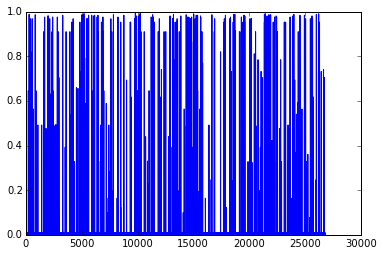

In [22]:
plt.plot(model.doc_topic_[:,5])
print model.doc_topic_[:,1]
print model.ndz_.sum()

In [ ]:
print('Building frequency distribution')

for i, popword in enumerate(allTheWords):
    if "'" in popword[0]:
        continue
        
    con = sqlite3.connect('alltweets_scored.db')
    query = "SELECT * from tweets WHERE content LIKE '%%%s%%' COLLATE NOCASE"%popword[0]
    data = pd.read_sql(query,con)
    
    a = [date[5:10] for date in data['created_at']]
    cnt = collections.Counter(a)
    
    mad = mean_abs_dev(cnt.values())
    k = 3.8
    outliers = [x for x in cnt.values() if x > k*mad]
    important = 0
    
    for outlier in outliers:
        for date, reps in cnt.iteritems():
            if reps == outlier:
                important = important + 1
                if important == 1:
                    progress(i, tot)

                if mad == 0:
                    continue
                    
                coolWords.append({"word":popword[0],
                                "ratio":outlier/(k*mad),
                                "amount":outlier,
                                "date":date})


sortedlist = sorted(coolWords, key = operator.itemgetter('ratio'), reverse = True)

cleanWords = []
con = sqlite3.connect('alltweets_scored.db')
shortSorted = sortedlist[0:500]

print('Filtering output')
        
for i, data in enumerate(shortSorted):
    timesFound = data['amount']

    if timesFound>50:
        word = data['word']
        query = "SELECT * from tweets WHERE content LIKE '%%%s%%' COLLATE NOCASE"%word
        datum = pd.read_sql(query,con)
        
        unique = len(set(datum.username))
        
        if unique > 3:
            cleanWords.append({"word":data['word'],"ratio":data['ratio'],"amount":data['amount'],"date":data['date']})
            
    progress(i, len(shortSorted))

print len(cleanWords)

sortedClean = sorted(cleanWords, key = operator.itemgetter('amount'), reverse = True)

for cleanWord in sortedClean:
    print cleanWord['word'], cleanWord['date'], cleanWord['ratio'], cleanWord['amount']